# Prédiction du loyer à Bangkok

Ce projet a pour but de prédire le loyer à Bangkok. 
Pour réaliser ceci, j'ai récupéré la base de données sur [Kaggle](https://www.kaggle.com/datasets/thedevastator/predicting-bangkok-condominium-prices-using-web). J'utilise le fichier df_cleaned_for_ML_regression qui contient les données pré-nettoyées.

On met en œuvre un pipeline complet pour la préparation, le prétraitement des données, la construction d'un modèle de réseau de neurones convolutionnel 1D avec la bibliothèque Keras, sans oublier de faire l'évaluation des performances du modèle. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

## 1.Lecture des données
On lit les données à partir du fichier *.csv* à l'aide de la bibliothèque **Pandas**. Cela permet de créer le DataFrame avec lequel on va travailler par la suite. 

In [2]:
# Lecture des données à partir du fichier CSV 
df = pd.read_csv("archive\df_cleaned_for_ML_regression.csv")

# Prévisionnage des données
print(df.head())

                     name   district   latitude   longitude  year_built  \
0             101 Mansion  Bang Kapi  13.787435  100.631564        1991   
1  624 Condolette Ladprao  Bang Kapi  13.766348  100.649395        2011   
2     Adamas Ramkhamhaeng  Bang Kapi  13.752448  100.615507        1995   
3      Aspire Ladprao 113  Bang Kapi  13.770286  100.638799        2016   
4              B.R. Condo  Bang Kapi  13.768706  100.638876        1991   

   proj_area  nbr_buildings  nbr_floors  units  hospital  ...  \
0      23371              5           5  834.0      2.10  ...   
1       6476              2           8  471.0      1.80  ...   
2       4699              1          16  140.0      2.30  ...   
3       3816              1           8  270.0      0.68  ...   
4       7391              2          10  560.0      0.69  ...   

                 tran_name1                   tran_name2  \
0      Lat Phrao Toll Plaza  Yothin Phatthana Toll Plaza   
1      Lat Phrao Toll Plaza     Srinag

## 2. Prétraitement des données

### Encodage des variables catégoriques
Le dataset contient des variables catégoriques telles que 'district', 'tran_type1', 'tran_type2', 'tran_type3'... 

Ces variables doivent être converties en une forme numérique pour être utilisées dans le modèle. Avec *LabelEncoder()* et *OneHotEncoder()* on crée des nouvelles colonnes binaires pour chaque catégorie.

In [3]:
# Suppression de la colonne "name"
df = df.drop(columns=["name"])

# Pré-traitement des données catégoriques 
categorical_cols = ['district', 'tran_type1', 'tran_type2', 'tran_type3', 'tran_type4', 'tran_type5']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    ohe = OneHotEncoder()
    df_ohe = ohe.fit_transform(df[[col]])
    df_ohe = pd.DataFrame(df_ohe.toarray(), columns=[col + "_" + str(i) for i in range(df_ohe.shape[1])])
    df = pd.concat([df, df_ohe], axis=1)
    df = df.drop(columns=[col])

le = LabelEncoder()
for col in ['tran_name1', 'tran_name2', 'tran_name3', 'tran_name4', 'tran_name5']:
    df[col] = le.fit_transform(df[col])

### Mélange des données

On mélange aléatoirement pour éviter tout biais dans l'ordre d'arrivée des données. Cela permet de garantir que l'ordre des données n'affectera pas le modèle.


In [4]:
# Mélange des données
df = df.sample(frac=1)

## 3. Séparation des données

On divise le DataFrame en données d'entraînement *(X_train, y_train)* et données de validation *(X_val, y_val)*. Cela permet d'évaluer les performances du modèle sur un ensemble de données non utilisé pendant l'entraînement.

**X:** Les données d'entrée comprennent toutes les colonnes du DataFrame, à l'exception de la colonne "price_sqm" qui est la variable cible.

**Y:** Les données de sortie comprennent uniquement la colonne "price_sqm" (variable cible).

**train_test_split():** Cette fonction est utilisée pour diviser les données en ensembles d'entraînement et de validation. Les paramètres test_size spécifie la proportion de données à utiliser pour la validation (20% ici).

In [5]:
X = df.drop(columns=["price_sqm"])
Y = df[['price_sqm']]

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## 4. Création du modèle de réseau de neurones

Le modèle est construit à l'aide de la bibliothèque Keras. 

C'est un réseau de neurones convolutionnel 1D avec des couches Conv1D, MaxPooling1D, Flatten et Dense. 

Le modèle est compilé avec l'optimiseur **'adam'** et la fonction de perte **'mean_squared_error'**.

In [6]:
# Création du modèle de réseau de neurones
model = Sequential()

# Ajout de couches
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compilation du modèle avec l'optimisateur et la fonction de perte
model.compile(optimizer='adam', loss='mean_squared_error')

## 5. Entraînement du modèle

Le modèle est entraîné sur les données d'entraînement avec **500** époques et un batch size de **32**. Il est possible d'augmenter les époques pour obtenir des résultats plus viables.

In [7]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500

26/26 [==============================] - 2s 7ms/step - loss: 13740436480.0000
Epoch 2/500
26/26 [==============================] - 0s 5ms/step - loss: 10787007488.0000
Epoch 3/500
26/26 [==============================] - 0s 6ms/step - loss: 8665403392.0000
Epoch 4/500
26/26 [==============================] - 0s 6ms/step - loss: 6762634752.0000
Epoch 5/500
26/26 [==============================] - 0s 5ms/step - loss: 4960911360.0000
Epoch 6/500
26/26 [==============================] - 0s 6ms/step - loss: 3957833472.0000
Epoch 7/500
26/26 [==============================] - 0s 5ms/step - loss: 3670108928.0000
Epoch 8/500
26/26 [==============================] - 0s 6ms/step - loss: 3560179200.0000
Epoch 9/500
26/26 [==============================] - 0s 6ms/step - loss: 3456278528.0000
Epoch 10/500
26/26 [==============================] - 0s 6ms/step - loss: 3372751104.0000
Epoch 11/500
26/26 [==============================] - 0s 6ms/step - loss: 3315241216.0000
Epoch 12/500
26/

## 6. Prédiction et évaluation

Les valeurs de sortie sont prédites pour les données de validation, et l'erreur absolue moyenne (MAE) entre les valeurs prédites et réelle est calculée. 

In [8]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)

print("MAE:",mae)

7/7 [==============================] - 0s 3ms/step
MAE: 30863.487457873776


## 7. Visualisation des performances du modèle

Voilà un graphique permettant de visualiser les performances du modèle. 

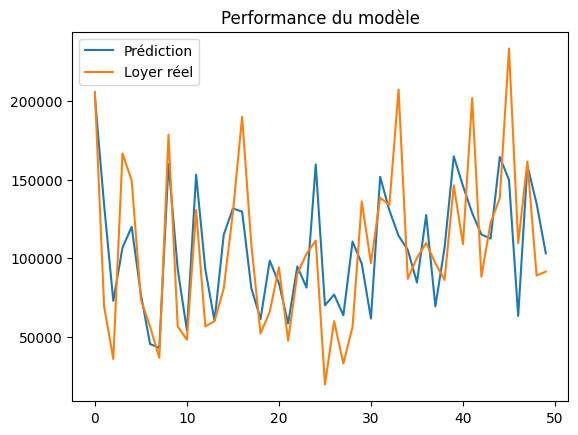

In [9]:
plt.title('Performance du modèle')
plt.plot(list(y_pred)[:50], label='Prédiction')
plt.plot(y_val['price_sqm'].tolist()[:50], label='Loyer réel')
plt.legend()

## Conclusion 

La MAE de 25889 indique l'erreur moyenne absolue entre les valeurs prédites et réelles. En gros, les prédictions du modèle diffèrent d'un prix de 25889 par mètre carré.

Plus la MAE est basse, plus le modèle est précis.